# Medical Imaging
## 2020-2021

### Lab 1

### Group 13:
- Alexandra Gonçalves | nº89785
- Catarina Carvalho   | nº89791
- Diogo Vieira        | nº89794
- Mariana Mourão      | nº98473

### Importing relevant libraries

In [4]:
import numpy as np
from scipy.io import loadmat
from matplotlib import pyplot as plt
from roipoly import RoiPoly
from scipy.ndimage import gaussian_filter
import math

In [6]:
x = loadmat('ct.mat')

# Select variable 'ct' and convert it from dictionary to numpy array
im_ct = np.array(x['ct'])

# Convert CT indexes to attenuation coefficients
mu_h2o = 0.206; # attenuation coefficient in water (units of cm^-1)
im_ac  = mu_h2o * (1 + im_ct/1000); # (units of cm^-1)

# Print image size
[rows, cols, slices] = im_ct.shape # im_ac has the same dimensions
print(rows, cols, slices)

512 512 256


## 1. CT Indexes and Attenuation Coefficients Histograms

For computing the histograms of the CT indexes and  attenuation coefficients, 256 bins were defined, with each bin representing a range of values that is mappable to the grayscale (intensities that range from 0 to 255). This way, the computed histograms correctly quantitize the number of pixels with a given gray intensity, allowing to posteriorly perform an informative selection of appropriate intensity ranges for displaying CT planar images.

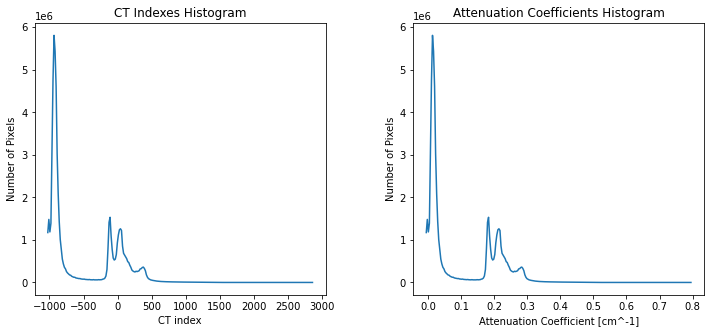

In [7]:
# CT Indexes Histogram

histogram, bin_edges = np.histogram(im_ct, bins=256) 
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("CT Indexes Histogram")
plt.xlabel("CT index")
plt.ylabel("Number of Pixels")
plt.plot(bin_edges[0:-1], histogram)


# Attenuation Coefficients Histogram

histogram, bin_edges = np.histogram(im_ac, bins=256) 
plt.subplot(1, 2, 2)
plt.title("Attenuation Coefficients Histogram")
plt.xlabel("Attenuation Coefficient [cm^-1]")
plt.ylabel("Number of Pixels")
plt.plot(bin_edges[0:-1], histogram)
plt.subplots_adjust(wspace=0.3)

## 2. Display of Representative Slices in the Axial, Sagittal and Coronal Views

In this exercise, a representative visualization is done by accessing 16 equally spaced slices in each orientation - axial $(x,y)$, sagittal $(x,z)$ and coronal $(y,z)$. 

For analyzing the image orientation in each view, the corresponding middle slices were accessed. 

Text(0.5, 1.0, 'Coronal planar Image')

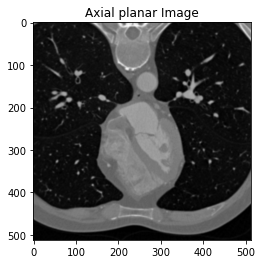

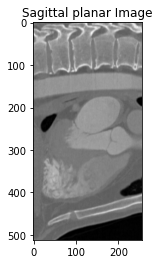

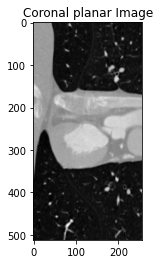

In [8]:
ax_slice  = np.reshape(im_ac[:, :, slices // 2], [rows, cols])
sag_slice = np.reshape(im_ac[:, cols // 2, :], [rows, slices])
cor_slice = np.reshape(im_ac[rows // 2, :, :], [cols, slices])

plt.figure()
plt.imshow(ax_slice, cmap="gray")
plt.title('Axial planar Image')

plt.figure()
plt.imshow(sag_slice, cmap="gray")
plt.title('Sagittal planar Image')

plt.figure()
plt.imshow(cor_slice, cmap="gray")
plt.title('Coronal planar Image')

For correcting the slices orientations it each view, the following was taken into consideration:
- For the axial planar images, the spinal cord should be represented in the bottom edge of the images, with the descending aorta on the right side of the image. 
- For the sagittal planar images, the spinal cord should be represented vertically, being on the left side of the images. 
- For the coronal planar images, the spinal cord should be represented vertically, with the apex of the heart oriented to the lower-right side of the image.

In this sense, it was necessary to rotate both sagittal and coronal slices by 90º degrees counterclock-wise (function `np.rot90`), and the axial slices rotate by 180º degrees (applying the command `origin='lower'`).

Regarding the intensity range, all the different slices come from the same 3D object, thus their intensities should be similar. Analyzing the histogram of the attenuation coefficients, it is observed that the range of approximatelly $[0.3, 0.8] cm^{-1}$ doesn't have any pixels associated (0 counts in the histogram), with the corresponding gray intensities not being attributed to any pixel, resulting in an image with non-optimized contrast. To broaden the range of gray intensities being attributed to the pixels, the range of the attenuation coefficients was adjusted to $vmin = 0$ and $vmax = 0.3$, with the `imshow` function normalizing this range to the grayscale. Note that the values which are lower or greater than $vmin$ and $vmax$, respectively, are set to 0 and 255 in the grayscale. 

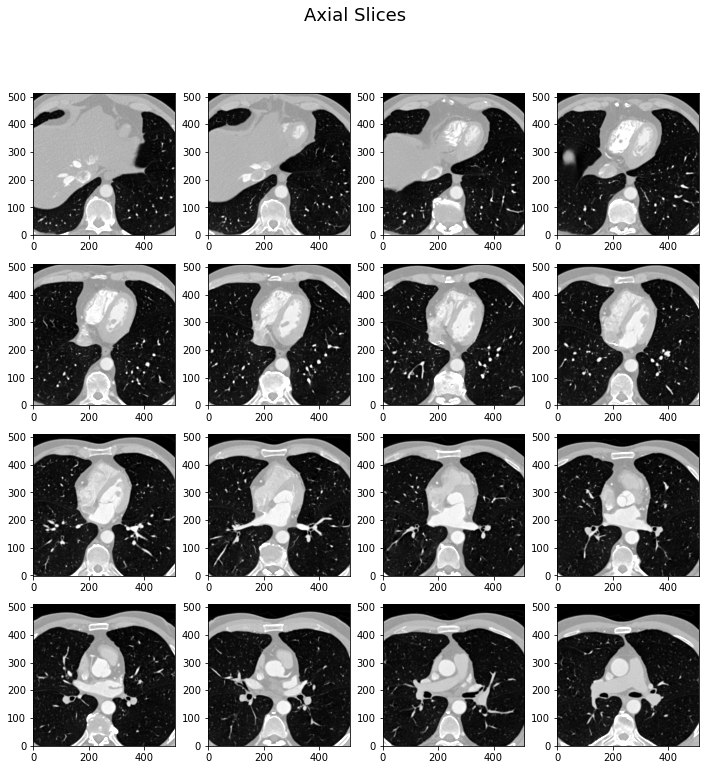

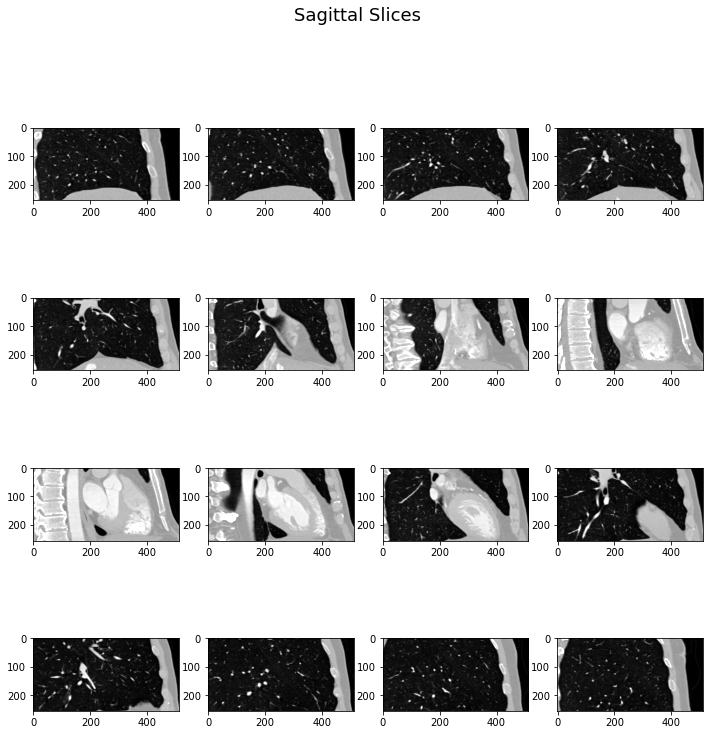

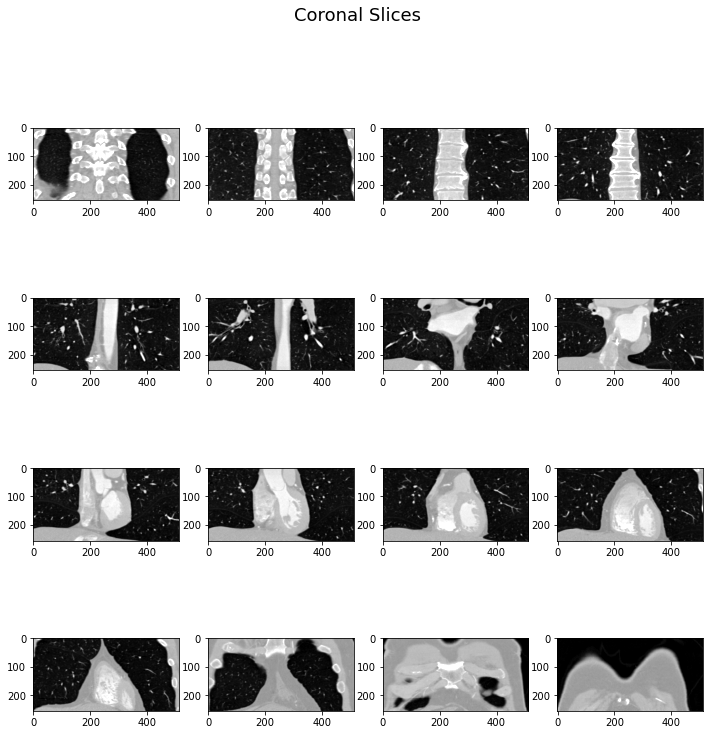

In [9]:
n_slices = 16 # number of slices to display 

# Axial View (x and y) 
slice_jump = slices//n_slices

plt.figure(figsize=(12,12))
plt.suptitle('Axial Slices',fontsize = 18)
for n in range(1, 17):
    sl = 1 + (n-1)*slice_jump
    axsltmp = np.reshape(im_ac[:, :, sl], [rows, cols])
    plt.subplot(4, 4, n)
    plt.imshow(axsltmp, cmap='gray', origin='lower', vmin=0, vmax=0.3)  
    plt.subplots_adjust(wspace=0.2,hspace=0.2)
    
# Sagittal View (x and z) 
slice_jump = cols//n_slices

plt.figure(figsize=(12,12))
plt.suptitle('Sagittal Slices',fontsize = 18)
for n in range(1, 17):
    sl = 1 + (n-1)*slice_jump
    sagltmp = np.reshape(im_ac[:, sl, :], [rows, slices])
    plt.subplot(4, 4, n)
    plt.imshow(np.rot90(sagltmp), cmap='gray', vmin=0, vmax=0.3)
    plt.subplots_adjust(wspace=0.2,hspace=0.2)
    
# Coronal View (y and z) 
slice_jump = rows//n_slices 

plt.figure(figsize=(12,12))
plt.suptitle('Coronal Slices',fontsize = 18)
for n in range(1, 17):
    sl = 1 + (n-1)*slice_jump
    corltmp = np.reshape(im_ac[sl, :, :], [cols, slices])
    plt.subplot(4, 4, n)
    plt.imshow(np.rot90(corltmp), cmap='gray', vmin=0, vmax=0.3)
    plt.subplots_adjust(wspace=0.2,hspace=0.2)

The following things can be observed on these slices:

- Axial Slices: the first slices have the liver on the top right; then, the heart starts to be seen in the middle of the images. The black spaces correspond to the lungs. Notice that the left lung is on the right side of the image and vice-versa.

- Sagittal Slices: the first slices show the right lung with the spinal cord on the left side; then, we start to see the heart, and finally, we see the left lung.

- Coronal Slices: the first slices show the back of the spinal cord; then, we progressively move forward until the heart is seen.

## 3. Simulation of planar X-ray

In [10]:
#voxel size is given by FOV/Npx, with FOV=18x18x24 cm^3 
voxelx = 18/rows;
voxely = 18/cols;
voxelz = 24/slices;

# FOV -> range of distances that we are covering in the physical limits of 
# the body

In general, the attenuation equation is given by:

$$I = I_0 e^{-\mu \cdot \sigma}$$

In planar X-ray imaging, the X-ray beam is transmitted through the object along one direction, consisting the object of a distribution of attenuation coefficients. For this case, the X-ray beam is transmitted along the $x$ direction, resulting in an image in the normal direction (coronal plane). This transmission process leads to the attenuation of the incident X-ray beam $I_0(y,z)$, resulting an image of intensity $I(y,z)$ which represents the intensity of the detected X-ray beam, reflecting the projection of the attenuation coefficients across the beam direction. This is translated by the following attenuation equation in the discrete domain:

$$I(y,z) = I_0(y,z) e^{-\sum_{x=1}^\text{rows}\mu(x,y,z) \cdot \Delta{x}},$$ 

with $\Delta{x}$ being the voxel dimension along the x direction and $I_0 = 1000$ photons/pixel;

In [12]:
#incident X ray beam I0 = 1000 photons/pixel
I0 = 1000;

x_sum = np.sum(im_ac, axis = 0)
Iyz = I0*np.exp(-x_sum*voxelx)

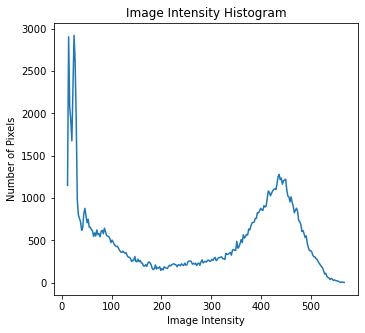

In [13]:
histogram, bin_edges = np.histogram(Iyz, bins=256) 
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Image Intensity Histogram")
plt.xlabel("Image Intensity")
plt.ylabel("Number of Pixels")
plt.plot(bin_edges[0:-1], histogram)

Text(0, 0.5, 'z direction')

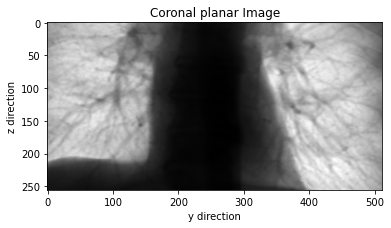

In [14]:
plt.imshow(np.rot90(Iyz), cmap='gray')
plt.title('Coronal planar Image')
plt.xlabel('y direction')
plt.ylabel('z direction')

## 4. a) Simulate the planar X ray image by using twice the X ray tube voltage


The intensity of the image depends on the square of the tube voltage:

$$I \propto (kV_p)^2$$ 

Therefore, using twice the tube voltage is equivalent to multiplying the image intensity by 4:

$$ (kV_p)_2 = 2\cdot(kV_p)_1$$
$$ I_2 \propto (kV_p)_2^2 = (2\cdot(kV_p)_1)^2 = 4\cdot(kV_p)_1^2 \Rightarrow \frac{I_2}{4} \propto (kV_p)_1^2 $$
$$ \Rightarrow I_2 = 4 I_1 $$

$I_1$ was already computed in exercise 3.

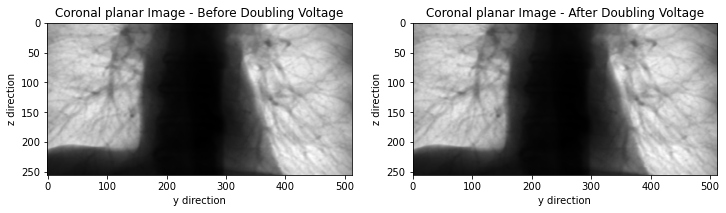

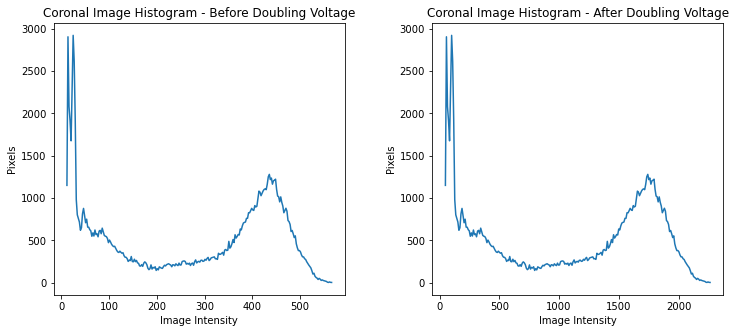

In [15]:
new_planar_image_yz = 4*Iyz

# Compairing Coronal Images before and after doubling voltage
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.imshow(np.rot90(Iyz), cmap='gray')
plt.title('Coronal planar Image - Before Doubling Voltage')
plt.xlabel('y direction')
plt.ylabel('z direction')

plt.subplot(1, 2, 2)
plt.imshow(np.rot90(new_planar_image_yz), cmap='gray')
plt.title('Coronal planar Image - After Doubling Voltage')
plt.xlabel('y direction')
plt.ylabel('z direction')

# Create the histograms 
plt.figure(figsize=(12,5))

histogram, bin_edges = np.histogram(Iyz, bins=256) 
plt.subplot(1, 2, 1)
plt.title("Coronal Image Histogram - Before Doubling Voltage")
plt.xlabel("Image Intensity")
plt.ylabel("Pixels")
plt.plot(bin_edges[0:-1], histogram)

histogram, bin_edges = np.histogram(new_planar_image_yz, bins=256) 
plt.subplot(1, 2, 2)
plt.title("Coronal Image Histogram - After Doubling Voltage")
plt.xlabel("Image Intensity")
plt.ylabel("Pixels")
plt.plot(bin_edges[0:-1], histogram)
plt.subplots_adjust(wspace=0.3)

By analysing the displayed results, it is concluded that doubling the x-ray voltage changes the range of intensities on the projection plane by a factor of 4 (as mathematically demonstrated), maintaning the distribution of pixels as before. This way, it could be expected that the intensities on the resulting image would increase proportionally. However, this isn't verified in the displayed images, since the `imshow` function normalizes the range of intensities to the grayscale (0 to 255), explaining the reason for the image to have the same intensity distribution. To clarify, the histograms are going to be displayed with the horizontal axis having the grayscale value:

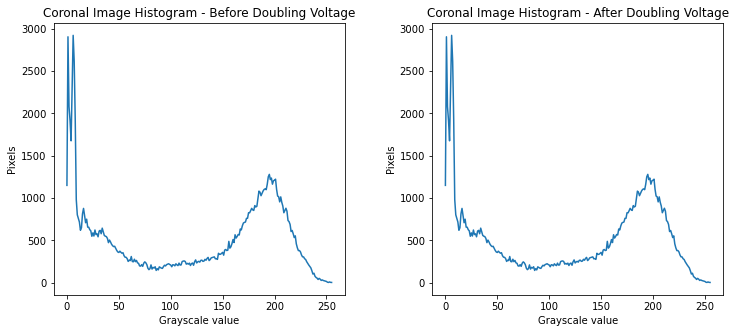

In [16]:
# Create the histograms 
plt.figure(figsize=(12,5))

histogram, bin_edges= np.histogram(Iyz, bins=256) 
plt.subplot(1, 2, 1)
plt.title("Coronal Image Histogram - Before Doubling Voltage")
plt.xlabel("Grayscale value")
plt.ylabel("Pixels")
plt.plot(histogram)

histogram, bin_edges = np.histogram(new_planar_image_yz, bins=256) 
plt.subplot(1, 2, 2)
plt.title("Coronal Image Histogram - After Doubling Voltage")
plt.xlabel("Grayscale value")
plt.ylabel("Pixels")
plt.plot(histogram)
plt.subplots_adjust(wspace=0.3)

We can conclude that changing the voltage of the X-ray tube does not change digital X-ray images. However, if we used an analog screen-film instead, the results would be different:
- an increase in the X-ray tube voltage would result in an increase in the image intensity, because we would be increasing the number of photons generated. Therefore, the Signal to Noise Ratio (SNR) would increase.
- an increase in the X-ray tube voltage would also increase the photon energies, therefore increasing the amount of Compton scattering in relation to the amount of photoelectric effect. Therefore, the constrast of the image would decrease.

### 4. b) Simulate the planar X ray image by projecting along y

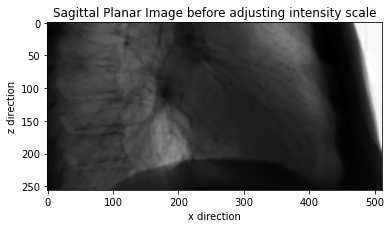

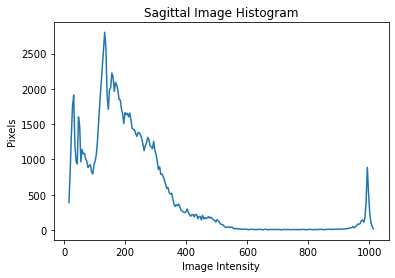

In [17]:
# Create the planar image
y_sum = np.sum(im_ac, axis=1) # Sum the attenuation coefficients in the y direction (saggital image), 
# being the projection of the attenuation coefficients across the beam direction

Ixz = I0*np.exp(-y_sum*voxely)

# See the resulting image
plt.figure()
plt.imshow(np.rot90(Ixz), cmap='gray')
plt.title('Sagittal Planar Image before adjusting intensity scale')
plt.xlabel('x direction')
plt.ylabel('z direction')

# Create the histogram
histogram, bin_edges = np.histogram(Ixz, bins=256) 
plt.figure()
plt.title("Sagittal Image Histogram")
plt.xlabel("Image Intensity")
plt.ylabel("Pixels")
plt.plot(bin_edges[0:-1], histogram)


By analyzing the sagittal image and the corresponding histogram, an extreme peak of intensity can be observed, approximately centered in 1000, these pixels being attributed to the brightest intensities on the image (region on the right side of the image). This region results from photons not contacting with any material before reaching the X-ray detector, since there is no material that can attenuate them there. This drastical difference in intensity doesn't convey any relevant information, thus, once again, the range of intensities will be adjusted in order to increase the intensity contrast on the image. For this, it was set  𝑣𝑚𝑖𝑛=0  and  𝑣𝑚𝑎𝑥=600, with the `imshow` function normalizing this range to the grayscale. Note that the values which are lower or greater than vmin and vmax, respectively, are set to 0 and 255 in the grayscale.

Text(0, 0.5, 'z direction')

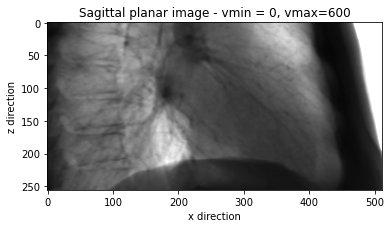

In [18]:
plt.figure()
plt.title('Sagittal planar image - vmin = 0, vmax=600')
plt.imshow(np.rot90(Ixz), cmap='gray', vmin=0, vmax=600)
plt.xlabel('x direction')
plt.ylabel('z direction')

The intensity display scale can be tuned for producing different types of image contrast, giving complementary information when comparing the tissues. 

In [21]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def f(v_max):
    plt.figure()
    plt.title('Sagittal planar image - vmin = 100, vmax=v_max')
    plt.xlabel('x direction')
    plt.ylabel('z direction')
    return plt.imshow(np.rot90(Ixz), cmap='gray', vmin=100, vmax=v_max)
    
interact(f, v_max=(100,1000,100));

interactive(children=(IntSlider(value=500, description='v_max', max=1000, min=100, step=100), Output()), _dom_…